## Loading Data

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
from torch.utils.data import DataLoader
from dataset.dataset import ForexDataset
from utils import get_sequence_start_indices

In [3]:
# === CONFIG ===
CHECKPOINT_PATH = r'..\lightning_logs\gru_m5\version_1\checkpoints\best_checkpoint.ckpt'

DATA_PATH = "../data/processed/usdjpy-bar-2025-01-01-2025-05-12_processed.pkl"
FEATURES_COLS = ['label']
SEQUENCE_LENGTH = 6
TARGET_COLS = ['label']
HORIZON = 1
STRIDE = 1

In [4]:
df = pd.read_pickle(DATA_PATH)

IDs = get_sequence_start_indices(
    df,
    sequence_length=SEQUENCE_LENGTH,
    horizon=HORIZON,
    stride=STRIDE,
    group_col='time_group',
)

test_dataset = ForexDataset(
    df, IDs, SEQUENCE_LENGTH, HORIZON, FEATURES_COLS, TARGET_COLS
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1024,
    shuffle=False
)

In [15]:
idx = IDs[0]
idx

9

In [16]:
df.loc[idx:idx+6]

,timestamp,open,high,low,close,volume,time_group,close_delta,close_return,close_direction,prob_down,prob_flat,prob_up,label
9,2025-01-01 22:15:00,157.2400,157.240,157.2370,157.2375,12.000000,2,0.0000,0.000000,flat,0.0,1.0,0.0,1
10,2025-01-01 22:16:00,157.2400,157.240,157.2375,157.2400,32.400001,2,0.0025,0.000016,flat,0.0,1.0,0.0,1
11,2025-01-01 22:17:00,157.2390,157.240,157.2375,157.2400,14.400001,2,0.0000,0.000000,flat,0.0,1.0,0.0,1
12,2025-01-01 22:18:00,157.2375,157.240,157.2375,157.2375,6.600000,2,-0.0025,-0.000016,flat,0.0,1.0,0.0,1
13,2025-01-01 22:19:00,157.2400,157.240,157.2375,157.2395,19.200001,2,0.0020,0.000013,flat,0.0,1.0,0.0,1
14,2025-01-01 22:20:00,157.2400,157.268,157.2260,157.2595,71.700002,2,0.0200,0.000127,up,0.0,0.0,1.0,2
15,2025-01-01 22:21:00,157.2660,157.266,157.2585,157.2615,16.560000,2,0.0020,0.000013,flat,0.0,1.0,0.0,1


In [17]:
df.loc[idx+6+1-1]

timestamp          2025-01-01 22:21:00
open                           157.266
high                           157.266
low                           157.2585
close                         157.2615
volume                           16.56
time_group                           2
close_delta                      0.002
close_return                  0.000013
close_direction                   flat
prob_down                          0.0
prob_flat                          1.0
prob_up                            0.0
label                                1
Name: 15, dtype: object

## Loading Model

In [5]:
import torch
from models.gru_model import GRUModule

In [6]:
model = GRUModule.load_from_checkpoint(CHECKPOINT_PATH)
model.to('cpu')

GRUModule(
  (model): GRUModel(
    (gru): GRU(1, 64, num_layers=2, batch_first=True, dropout=0.3)
    (linear): Linear(in_features=64, out_features=3, bias=True)
    (softmax): Softmax(dim=1)
  )
  (criterion): CrossEntropyLoss()
)

## Plotting Predictions

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [8]:
def plot_confusion_matrix(y_true, y_pred, class_names=None):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

In [9]:
def plot_class_predictions(y_pred, y_true):
    plt.figure(figsize=(12, 4))
    plt.scatter(range(len(y_pred)), y_pred, label="Predicted")
    plt.scatter(range(len(y_true)), y_true, label="Ground Truth")
    plt.title("Classification Predictions vs Ground Truth")
    plt.xlabel("Sample Index")
    plt.ylabel("Class")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

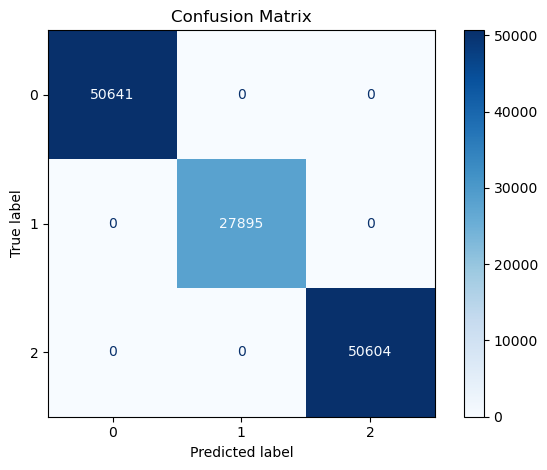

In [10]:
y_pred = []
y_true = []
for x, y, _ in (iter(test_loader)):
    with torch.no_grad():
        _, probs = model(x)
        pred_classes = torch.argmax(probs, dim=1)
        y_pred.extend(pred_classes)
        y_true.extend(y)
plot_confusion_matrix(y_pred, y_true)

In [11]:
from sklearn.metrics import classification_report

print(classification_report(y, pred_classes, target_names=["Sell", "Hold", "Buy"]))

              precision    recall  f1-score   support

        Sell       1.00      1.00      1.00        50
        Hold       1.00      1.00      1.00        18
         Buy       1.00      1.00      1.00        48

    accuracy                           1.00       116
   macro avg       1.00      1.00      1.00       116
weighted avg       1.00      1.00      1.00       116

